# Predicting the Condition of Tanzanian Water Systems

## Introduction

This analysis was performed with the goal of providing a way to predict the conditions of water wells in Tanzania for those who may want to use it (non profit groups, public works officials, etc). Using models constructed from the scikit-learn library, we can create a model that will help us predict the condition of water wells based on their information.

## Business Problem

The ongoing water crisis in Africa has made it difficult for the people in its villages to obtain clean, sanitary water, and in recent years an increasing number of non-profit organizations have pooled donations across the globe towards an effort to provide water sources for these villages. Thousands of wells have been drilled in Africa so far, and many more continue to be developed across the continent. 

While planning out the best locations to drill new wells is the best way to ensure more Africans have access to clean water, the process of drilling new wells is extensive and requires a large amount of resources, finances, and labor. It's also important to ensure that the wells that are already present are functional in the meantime so that villages have sustainable access to clean water. By also figuring out how to allocate the necessary  funds and labor necessary to perform maintenance work on pre-existing wells, we can ensure that new wells can be drilled without unnecessarily neglecting others.

Using the scikit-learn machine learning library, we will test out models that will allow us to predict the condition of water wells in Tanzania based on information about these wells such as when they were constructed, the extraction methods utilized, etc. While the main focus of this analysis will be Tanzanian water wells, this may also provide the foundation for a predictive model that can be applied to water wells across the African continent.

## Exploring the data 

We start by importing the Python packages needed for this analysis:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, f1_score, confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline

We will be using data on water wells in Tanzania provided by [DrivenData](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/) from Taarifa and the Tanzanian Ministry of Water, which can be found in the repository's `data` folder. The data is split into labels and values, so I merge them together for now to explore the data by joining both data frames on the `id` column.

In [2]:
values_df = pd.read_csv('data/training-set-values.csv')
labels_df = pd.read_csv('data/training-set-labels.csv')
df = pd.merge(labels_df, values_df, on='id')
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

The raw dataset has many categories; some may not have impact on analysis, while others tend to contain repetitive information (e.g., `water_quality` and `quality_group`). Before proceeding, I drop the columns that would have the least effect our predictive models. For columns that tend to repeat themselves, I kept the columns that classified each entry into a specific subset, or "group".

In [4]:
well_df = df.drop(['date_recorded', 'funder', 'installer', 'longitude', 'latitude', 'num_private',
                   'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management',
                   'scheme_name', 'permit', 'extraction_type', 'management', 'management_group', 'payment',
                   'water_quality', 'quantity', 'source', 'waterpoint_type', 'wpt_name', 'district_code',
                   'region_code', 'basin', 'extraction_type_group', 'source_class', 'payment_type'], 
                  axis=1)
well_df.head()

,id,status_group,amount_tsh,gps_height,population,construction_year,extraction_type_class,quality_group,quantity_group,source_type,waterpoint_type_group
0,69572,functional,6000.0,1390,109,1999,gravity,good,enough,spring,communal standpipe
1,8776,functional,0.0,1399,280,2010,gravity,good,insufficient,rainwater harvesting,communal standpipe
2,34310,functional,25.0,686,250,2009,gravity,good,enough,dam,communal standpipe
3,67743,non functional,0.0,263,58,1986,submersible,good,dry,borehole,communal standpipe
4,19728,functional,0.0,0,0,0,gravity,good,seasonal,rainwater harvesting,communal standpipe


In [5]:
well_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   gps_height             59400 non-null  int64  
 4   population             59400 non-null  int64  
 5   construction_year      59400 non-null  int64  
 6   extraction_type_class  59400 non-null  object 
 7   quality_group          59400 non-null  object 
 8   quantity_group         59400 non-null  object 
 9   source_type            59400 non-null  object 
 10  waterpoint_type_group  59400 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 5.4+ MB


In [6]:
well_df.describe()

,id,amount_tsh,gps_height,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,30500.000000,2013.000000


Since we are focusing on being able to distinguish functional wells from non-functional wells, we also want a general idea of how many wells in each data set are in each status group. Although "non-functional" and "functional needs repair" wells are both generally descriptive of wells that need to be repaired, I decided to keep those groups separate in case we need to prioritize wells that are still working over those that aren't for maintenance.

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


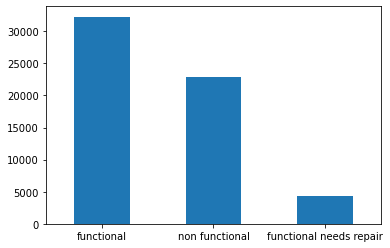

In [7]:
print(well_df['status_group'].value_counts())
well_df['status_group'].value_counts().plot(kind='bar', rot=0);

As shown in the bar graph above and in the normalized value counts(?) below, these classes are imbalanced.

In [8]:
print(df['status_group'].value_counts(normalize=True))

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64


## Data Preprocessing

Splitting condensed dataset into X and y

In [9]:
y = well_df['status_group']
X = well_df.drop(columns='status_group')

One hot encoding feature columns

In [10]:
X = pd.get_dummies(X)
X.head()

,id,amount_tsh,gps_height,population,construction_year,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,...,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,69572,6000.0,1390,109,1999,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,8776,0.0,1399,280,2010,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,34310,25.0,686,250,2009,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,67743,0.0,263,58,1986,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,19728,0.0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


Reviewing the general information of our X dataframe

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 36 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   id                                        59400 non-null  int64  
 1   amount_tsh                                59400 non-null  float64
 2   gps_height                                59400 non-null  int64  
 3   population                                59400 non-null  int64  
 4   construction_year                         59400 non-null  int64  
 5   extraction_type_class_gravity             59400 non-null  uint8  
 6   extraction_type_class_handpump            59400 non-null  uint8  
 7   extraction_type_class_motorpump           59400 non-null  uint8  
 8   extraction_type_class_other               59400 non-null  uint8  
 9   extraction_type_class_rope pump           59400 non-null  uint8  
 10  extraction_type_class_submersible 

## Creating Our Models

Splitting data into training and test sets. We do this to avoid data leakage by spliting off the data into random subsets before performing any preprocessing or tuning on the data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

### Random Forest

The first model I will test is the Random Forest classifier 

In [13]:
rf_pipeline = Pipeline([('ss', StandardScaler()), ('rf', RandomForestClassifier(max_depth=5, random_state=42))])

In [14]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('rf', RandomForestClassifier(max_depth=5, random_state=42))])

In [15]:
cross_val_score(rf_pipeline, X, y, cv=5)

array([0.703367  , 0.7       , 0.70799663, 0.70749158, 0.71237374])

Since we are focused on identifying wells that need repair based on the information given to us in the data, we want a metric that will allow us to judge how well a model can minimize the number of false negatives. In this case, we want a model that will avoid classifying a non-functional or a functional well in need of repair as a pure functional well. For this, I use sklearn's `recall_score` function to measure this metric based on the three labels of our data. I will be focusing on the recall scores for non functional and functional needs repair wells; while these classes are separate, we will assume that both indicate that a well is in either immediate or eventual need for repair.

In [16]:
rf_y_pred = rf_pipeline.predict(X_test)
recall_score(y_test, rf_y_pred, average=None)

array([0.9686048 , 0.        , 0.46584065])

Confusion matrix highlighting how accurate our model was in identifying true positives and negatives

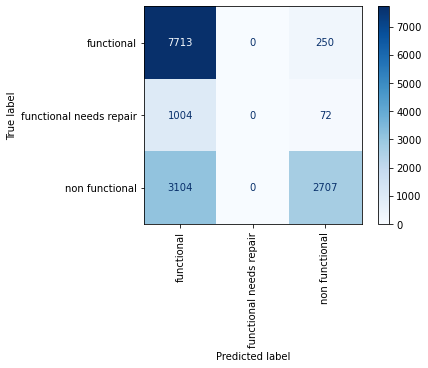

In [40]:
plot_confusion_matrix(rf_pipeline, X_test, y_test, xticks_rotation='vertical', cmap='Blues')

I also use the F1 score algorithm, which averages the precision and recall scores of all the model's classes to measure the overall performance of the model. 

In [18]:
f1_score(y_test, rf_y_pred, average='micro')

0.7016835016835017

### Gaussian Naive Bayes

Next, I use a Gaussian Naive Bayes model, which is derived by Bayes' Theorem

In [19]:
gnb_pipeline = Pipeline([('ss', StandardScaler()), ('gnb', GaussianNB())])

In [20]:
gnb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('gnb', GaussianNB())])

In [21]:
cross_val_score(gnb_pipeline, X, y, cv=5)

array([0.22415825, 0.29200337, 0.20505051, 0.24654882, 0.2280303 ])

In [22]:
gnb_y_pred = gnb_pipeline.predict(X_test)
recall_score(y_test, gnb_y_pred, average=None)

array([0.02511616, 0.95817844, 0.35931853])

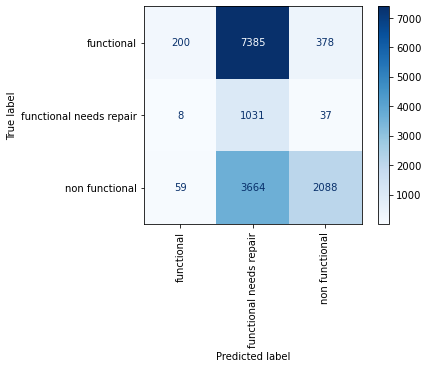

In [41]:
plot_confusion_matrix(gnb_pipeline, X_test, y_test, xticks_rotation='vertical', cmap='Blues')

In [24]:
f1_score(y_test, gnb_y_pred, average='micro')

0.2235016835016835

### Support Vector Machine (SVM)

I will also run a third model, an SVM

In [25]:
svc_pipeline = Pipeline([('ss', StandardScaler()), ('svm', svm.SVC())])

In [26]:
svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('svm', SVC())])

In [27]:
cross_val_score(svc_pipeline, X, y, cv=5)

array([0.71877104, 0.71313131, 0.72340067, 0.72112795, 0.7229798 ])

In [28]:
svc_y_pred = svc_pipeline.predict(X_test)
recall_score(y_test, svc_y_pred, average=None)

array([0.94913977, 0.00371747, 0.53278265])

In [29]:
confusion_matrix(y_test, svc_y_pred)

array([[7558,    1,  404],
       [ 985,    4,   87],
       [2713,    2, 3096]], dtype=int64)

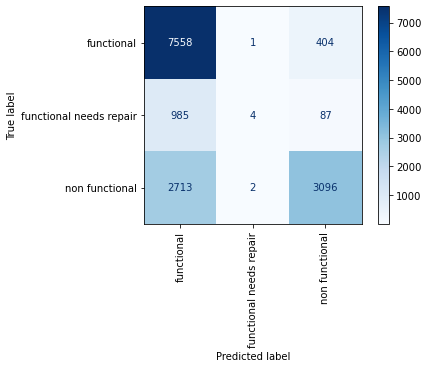

In [42]:
plot_confusion_matrix(svc_pipeline, X_test, y_test, xticks_rotation='vertical', cmap='Blues')

In [30]:
f1_score(y_test, svc_y_pred, average='micro')

0.7177104377104376

### Tuning our best model

It seems that our SVM model performed the best in predicting whether a well was either non functional or functional but needs repair (using default values found in the sklearn package). With this in mind, we can perform hyperparameter tuning on this model using the GridSearchCV algorithm to find the optimal hyperparameters for our model.

## Evaluation and Conclusion

- Random Forest performs the best
- Naive Bayes is our worst model
- SVM is

### Next Steps

- Do more research on geological factors that might impact the performance and condition of water wells
- For the sake of simplicity and performance, these models do not include specific subtypes of the attributes included (e.g. extraction types). We could create a model in the future for each attribute that takes these subtypes into account for further understanding of which wells need repair.
- If we want to broaden our model to accomodate for wells across Africa, we can run our best model again provided data on water wells from other regions in Africa